In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras import layers
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.models import SimilarityModel
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
movie_df = pd.read_csv("data/movie.csv")
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [4]:
rating_df = pd.read_csv("data/rating.csv")
rating_df = rating_df.drop("timestamp", axis=1)
rating_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0


In [5]:
num_of_movie = len(movie_df["title"].unique())
num_of_user = len(rating_df["userId"].unique())
num_of_rating = len(rating_df["movieId"].unique())

print(f"Num of movies: {num_of_movie}")
print(f"Num of ratings given by users: {num_of_user}")
print(f"Num of movie ratings: {num_of_rating}")

Num of movies: 27262
Num of ratings given by users: 138493
Num of movie ratings: 26744


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 457.8 MB


In [8]:
movie_list = movie_df["title"].value_counts().keys()
count = movie_df["title"].value_counts()

movie_count = pd.DataFrame({"Movie-Title": movie_list, "Count": count}).reset_index(drop=True)
movie_count

,Movie-Title,Count
0,Aladdin (1992),2
1,Johnny Express (2014),2
2,Chaos (2005),2
3,Hamlet (2000),2
4,"20,000 Leagues Under the Sea (1997)",2
...,...,...
27257,Tai Chi Master (Twin Warriors) (Tai ji: Zhang ...,1
27258,Splitting Heirs (1993),1
27259,Sonatine (Sonachine) (1993),1
27260,"Snapper, The (1993)",1


In [9]:
rating_list = rating_df["rating"].value_counts().keys()
count = rating_df["rating"].value_counts()

rating_count = pd.DataFrame({"Ratings": rating_list, "Count": count}).reset_index(drop=True)
rating_count

,Ratings,Count
0,4.0,5561926
1,3.0,4291193
2,5.0,2898660
3,3.5,2200156
4,4.5,1534824
5,2.0,1430997
6,2.5,883398
7,1.0,680732
8,1.5,279252
9,0.5,239125


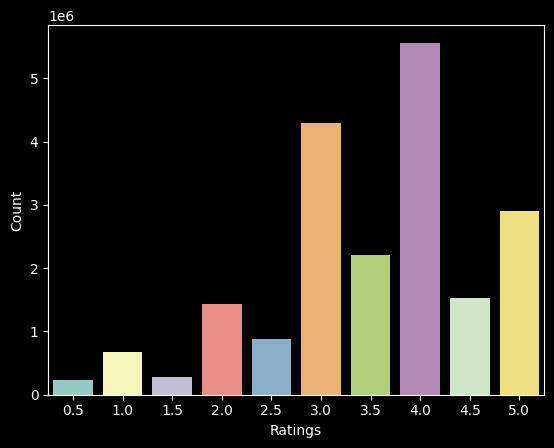

In [10]:
sns.barplot(data=rating_count, x='Ratings', y='Count')
plt.show()

In [11]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [12]:
rating_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [13]:
movie_df.duplicated().sum()

0

In [14]:
rating_df.duplicated().sum()

0

In [15]:
movie_df = movie_df[movie_df["genres"] != "(no genres listed)"]
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27272,131252,Forklift Driver Klaus: The First Day on the Jo...,Comedy|Horror
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure


In [16]:
rating_df = rating_df[rating_df["movieId"].isin(movie_df["movieId"])]
rating_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000260,138493,69644,3.0
20000261,138493,70286,5.0


In [17]:
new_df = movie_df.merge(rating_df)
new_df = new_df.drop("title", axis=1)
new_df

,movieId,genres,userId,rating
0,1,Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Adventure|Animation|Children|Comedy|Fantasy,11,4.5
...,...,...,...,...
19999897,131252,Comedy|Horror,79570,4.0
19999898,131254,Comedy,79570,4.0
19999899,131256,Comedy,79570,4.0
19999900,131258,Adventure,28906,2.5


In [18]:
new_df.duplicated().sum()

0

In [19]:
new_df.isnull().sum()

movieId    0
genres     0
userId     0
rating     0
dtype: int64

In [20]:
tfid = TfidfVectorizer()
tfid.fit(new_df["genres"])

tfid.get_feature_names()

c:\Users\Zis\anaconda3\envs\movies-rec\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'horror',
 'imax',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [21]:
tfidf_matrix = tfid.fit_transform(new_df["genres"])
matrix_dim = tfidf_matrix.shape[1]
matrix_dim

21

In [71]:
tfidf_matrix.todense()

matrix([[0.        , 0.36396776, 0.55843507, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.36396776, 0.55843507, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.36396776, 0.55843507, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.46084214, 0.        , ..., 0.        , 0.        ,
         0.        ]])